In [ ]:
# Import package
%%capture
import sys

if 'google.colab' in sys.modules:
    !sudo apt-get install -y fonts-nanum 
    !sudo fc-cache -fv
    !rm ~/.cache/matplotlib -rf
    !pip install konlpy
    !pip install squarify
    !pip install git+https://github.com/haven-jeon/PyKoSpacing.git
    !pip install git+https://github.com/ssut/py-hanspell.git
    !pip install googletrans==4.0.0-rc1
    !pip install gensim

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
import re
import numpy as np
import gensim
import tensorflow as tf

from gensim.models import Word2Vec
from tqdm.notebook import tqdm
from collections import Counter
from konlpy.tag import Okt
from hanspell import spell_checker
from pykospacing import Spacing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
# drive.mount
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
pip freeze > requirements.txt

## **3. 분석 모델 구축**

데이터 : Trip Advisor Hotel Reviews

구성 : 총 20491개의 리뷰

기타 : 1) 리뷰 별 별점 데이터도 포함되어 있음 2) 결측치, 중복 없음

### **3-1. Pre-processing, Tokenize**

In [ ]:
# 경로 지정
file_path = "/content/drive/MyDrive/Colab Notebooks/Study/Codestate_AI/Session4/Session4_Project/tripadvisor_hotel_reviews.csv"

# 파일 가져오기
df_trip = pd.read_csv(file_path)

In [ ]:
# 데이터 전처리 진행 
df_trip['Review_tokens'] = df_trip['Review']
text_desc = []

for text in df_trip['Review'] :
    text = text.replace('\'', '').replace('\n', '').strip()
    doc_tokens = re.sub(r"[^a-z0-9]", " ", str(text))
    doc_tokens = doc_tokens.replace('  ', ' ')
    text_desc.append(doc_tokens)

# 리스트를 데이터 프레임에 반영
df_trip.loc[:]['Review_tokens'] = text_desc

In [ ]:
# shape 및 label 확인
print(df_trip.shape)
print('-' * 80)
print(df_trip['Rating'].value_counts())

(20491, 3)
--------------------------------------------------------------------------------
5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64


In [ ]:
# label 변경 -> 1(매우 불만족), 2(불만족), 3(보통)을 하나로 / 4(만족), 5(매우 만족)을 하나로 통합
# 사유 1. 모델의 성능이 좋지 않을 것으로 예상되어
# 사유 2. 분석 목적에 비해 디테일하게 label이 구분되어 있어서
# (이번 분석에서는 고객들의 (불)만족 포인트만 짚으면 되며, 어느정도 (불)만족하였는지 등의 디테일 한 수치를 확인할 필요는 없음)

df_trip['Rating'] = df_trip['Rating'].replace(1, 3).replace(2, 3)
df_trip['Rating'] = df_trip['Rating'].replace(3, 0).replace(4, 1).replace(5, 1)

# 결과 확인
print(df_trip['Rating'].value_counts())

1    15093
0     5398
Name: Rating, dtype: int64


In [ ]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_sm")
tokenizer = Tokenizer(nlp.vocab)

In [ ]:
# 불용어 사전에 단어 추가
STOP_WORDS = nlp.Defaults.stop_words.union(['nt'])

# 불용어 처리 진행
tokens = []
for doc in tokenizer.pipe(df_trip['Review_tokens']):
    doc_tokens = []
    for token in doc:
        if (token.text not in STOP_WORDS) & (token.is_punct == False) :
            doc_tokens.append(token.text)
    tokens.append(doc_tokens)

# 리스트를 데이터 프레임에 반영
df_trip['Review_tokens_stop'] = tokens

# 결과 확인
df_trip = df_trip[['Review_tokens_stop','Rating']]
df_trip.head()

,Review_tokens_stop,Rating
0,"[nice, hotel, expensive, parking, got, good, d...",1
1,"[ok, special, charge, diamond, member, hilton,...",0
2,"[nice, rooms, 4, experience, hotel, monaco, se...",0
3,"[unique, great, stay, wonderful, time, hotel, ...",1
4,"[great, stay, great, stay, went, seahawk, game...",1


In [ ]:
# 파일 중간 저장
df_trip.to_csv("/content/drive/MyDrive/Colab Notebooks/Study/Codestate_AI/Session4/Session4_Project/df_trip.csv", header=True, index=False)

### **3-2. Word counts 확인**

In [ ]:
# 결과 분석 - 함수 생성
def word_count(docs):
    word_counts = Counter()
    word_in_docs = Counter()
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())
    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()
    wc['percent'] = wc['count'].apply(lambda x: x / total)
    wc = wc.sort_values(by='rank')
    wc['cul_percent'] = wc['percent'].cumsum()
    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [ ]:
# 결과 적용 및 확인
df_tok_result = word_count(df_trip['Review_tokens_stop'])
df_tok_result.head(10)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
69,hotel,16402,49874,1.0,0.024306,0.024306,0.800449
2,room,14206,35356,2.0,0.017231,0.041537,0.693280
40,great,11128,21482,3.0,0.010469,0.052007,0.543068
41,good,9402,17419,4.0,0.008489,0.060496,0.458836
224,staff,11768,16637,5.0,0.008108,0.068604,0.574301
35,stay,10193,15413,6.0,0.007512,0.076116,0.497438
50,nice,7500,12646,7.0,0.006163,0.082279,0.366014
242,rooms,8533,12408,8.0,0.006047,0.088326,0.416427
25,location,8363,11353,9.0,0.005533,0.093859,0.408130
523,stayed,8569,10500,10.0,0.005117,0.098976,0.418184


### **3-3. Words Translation**
- 구글 번역 Package를 불러와 전처리 된 데이터에 적용
- 특이사항 : 약 2만개의 리뷰 데이터를 하나의 코랩 파일에서 번역하는데 시간이 굉장히 오래 걸려 (약 8시간)

  코랩 파일을 3개로 나누어 각각 번역을 진행한 후 데이터를 통합 함

In [ ]:
# 번역 과정 코드 정리
'''
# 경로 지정
file_path = "/content/drive/MyDrive/Colab Notebooks/Study/Codestate_AI/Session4/Session4_Project/df_trip.csv"

# 파일 가져오기
df_trip = pd.read_csv(file_path)

# 필요한 칼럼 및 인덱스 분리
df_trip = df_trip[['Rating', 'Review_tokens_3']]

# 0~8000, 8001~16000, 16001~22000 순서로 데이터 분리
df_trip = df_trip.loc[16001:22000,]

# 변수 선언
translator = googletrans.Translator()

# list & column 생성
df_trip['Review_tokens_4'] = df_trip['Review_tokens_3']
index_list = []
trans_list = []

# 함수 정의
def translation(a):
    try :
        result = translator.translate(a, src='en', dest='ko').text
    except :
        result = '오류'
        print('오류')
    return result 

# 반복문으로 적용
for idx, i in tqdm(zip(df_trip.index, df_trip['Review_tokens_3'])) :
    result1 = translation(i)
    index_list.append(idx)
    trans_list.append(result1)

# 결과 적용
df_trip.loc[:]['Review_tokens_4'] = trans_list

# 결과 내보내기
df_trip.to_csv("/content/drive/MyDrive/Colab Notebooks/Study/Codestate_AI/Session4/Session4_Project/dvi_3.csv", header=True, index=False)
'''

In [ ]:
# 따로 진행한 번역 결과 데이터를 불러옴
# 경로 지정
file_path_1 = "/content/drive/MyDrive/Colab Notebooks/Study/Codestate_AI/Session4/Session4_Project/dvi_1.csv"
file_path_2 = "/content/drive/MyDrive/Colab Notebooks/Study/Codestate_AI/Session4/Session4_Project/dvi_2.csv"
file_path_3 = "/content/drive/MyDrive/Colab Notebooks/Study/Codestate_AI/Session4/Session4_Project/dvi_3.csv"

# 파일 가져오기
df_trip_div_1 = pd.read_csv(file_path_1)
df_trip_div_2 = pd.read_csv(file_path_2)
df_trip_div_3 = pd.read_csv(file_path_3)

# 결과 확인
df_trip_div = pd.concat([df_trip_div_1, df_trip_div_2, df_trip_div_3], axis=0)
df_trip_div.head()

,Rating,Review_tokens_3,Review_tokens_4
0,4,nice hotel expensive parking got good deal sta...,니스 호텔 비싼 주차 좋은 거래 숙박 호텔 기념일 늦은 저녁에 도착했습니다. 이전 ...
1,2,ok nothing special charge diamond member hilto...,OK 특별한 비용은 다이아몬드 회원 힐튼 결정 체인 샷 20 주년 기념 시애틀 시작...
2,3,nice rooms not 4 experience hotel monaco seatt...,멋진 객실 없음 4 체험 호텔 모나코 시애틀 좋은 호텔 NT 4 레벨 긍정적 인 멋...
3,5,unique great stay wonderful time hotel monaco ...,독특한 위대한 체류 멋진 시간 호텔 모나코 위치 훌륭한 짧은 산책로 주요 시내 쇼핑...
4,5,great stay great stay went seahawk game awesom...,훌륭한 체류 됨 Seahawk 게임 굉장한 건물 NT 불평 한 객실 거대한 직원 도...


In [ ]:
# 번역 간 오류가 나타난 row 삭제
df_trip_div = df_trip_div[df_trip_div['Review_tokens_4'] != '오류']

In [ ]:
# 전처리 진행 (이전 column과 동일한 방식으로)
df_trip_div['Review_tokens_ko'] = df_trip_div['Review_tokens_4']

# 기본 전처리
text_desc = []
for text in df_trip_div['Review_tokens_4'] :
    doc_tokens = re.sub(r"[^0-9ㄱ-ㅣ가-힣]", " ", str(text))
    doc_tokens = doc_tokens.replace('  ', ' ').replace('   ', ' ').replace('    ', ' ').replace('     ', ' ')
    text_desc.append(doc_tokens)

df_trip_div.loc[:]['Review_tokens_ko'] = text_desc

# 결과 확인
df_trip_div.head()

,Rating,Review_tokens_3,Review_tokens_4,Review_tokens_ko
0,1,nice hotel expensive parking got good deal sta...,니스 호텔 비싼 주차 좋은 거래 숙박 호텔 기념일 늦은 저녁에 도착했습니다. 이전 ...,니스 호텔 비싼 주차 좋은 거래 숙박 호텔 기념일 늦은 저녁에 도착했습니다 이전 리...
1,0,ok nothing special charge diamond member hilto...,OK 특별한 비용은 다이아몬드 회원 힐튼 결정 체인 샷 20 주년 기념 시애틀 시작...,특별한 비용은 다이아몬드 회원 힐튼 결정 체인 샷 20 주년 기념 시애틀 시작 ...
2,0,nice rooms not 4 experience hotel monaco seatt...,멋진 객실 없음 4 체험 호텔 모나코 시애틀 좋은 호텔 NT 4 레벨 긍정적 인 멋...,멋진 객실 없음 4 체험 호텔 모나코 시애틀 좋은 호텔 4 레벨 긍정적 인 멋진 ...
3,1,unique great stay wonderful time hotel monaco ...,독특한 위대한 체류 멋진 시간 호텔 모나코 위치 훌륭한 짧은 산책로 주요 시내 쇼핑...,독특한 위대한 체류 멋진 시간 호텔 모나코 위치 훌륭한 짧은 산책로 주요 시내 쇼핑...
4,1,great stay great stay went seahawk game awesom...,훌륭한 체류 됨 Seahawk 게임 굉장한 건물 NT 불평 한 객실 거대한 직원 도...,훌륭한 체류 됨 게임 굉장한 건물 불평 한 객실 거대한 직원 도움말 예약 된 ...


In [ ]:
# 불용어 지정
stop_list = "아 휴 아이구 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 의해서 연이서 이어서 잇따라 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 말하면 즉 구체적으로 말하자면 시작하여 시초에 이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓"
stop_list = stop_list.split()

stop_words_review_ko = set(stop_list + ['이', '하다', '가', '에', '한', '을', '은', '도', '를', '같다', '에서', '조금', '는', '으로', '이다', '의', '되다', '것', '들', '보다',
                             '안', '로', '점',  '인', '다', '아니다', '더', '되어다', '가다', '만', '못', '과', '이라', '수', '요', '그렇다', '2', '적', '나다', '1', '그리고', '고', '정도',
                             '그', '하고', '곳', '분', '느낌', '나', '받다', '들다', '에는', '등', '와', '부분', 'ㅠ', '까지', '기', '3', '인데', '하나', '라', '내', '서', '이나',
                             '제', '그냥', '듯', 'ㅠ', '매우', '싶다', '인지', '시', '객', '중', '돼다', '저', '엔', '거', '전', '지', '후', '랑', '대', '명', '잘', '성',
                             'ㅜㅜ', 'ㅎㅎ', '어', '위', '구', '건', '번', '외', '및', '아쉽다', '좋다', '먹다', '별로', 'ㅠㅠ', '딱하다', '게', '오다', '들어가다', '쪽', '면', '함',
                             '도', '이', '하다', '가', '에', '이다', '을', '들', '은', '는', '에서', '으로', '과', '의', '로', '를', '분들', '다',
                              '와', '적', '되어다', '것', '이라', '곳', '한', '인', '분', '하고', '고', '들다', '등', '또', '1', '까지', '때', '그리고',
                              '점', '2', '싶다', '잘', '더', '에도', '만', '라', '나', '요', '랑', '3', '역', '및', '이나', '개', '여서', '대',
                              '못', '4', 'ㅎㅎ', '내', '기', '서', '그', '면', '류', '게', '님', '맘', '두', '이상', '인데', '저', '제', '시',
                              '쉬', '박', '딱', '번', '중', '5', '일', '날', '움', '명', '전', '쪽', '함', '성', '장', '거', '듯', '해',
                              '엔', '편', '온', '임', '니', '하', '문', '잠', '식', '후',
                              '이', '하다', '가', '에', '한', '을', '은', '도', '를', '같다', '에서', '조금', '는', '으로', '이다', '의', '되다', '것', '들', '보다',
                              '안', '로', '점',  '인', '다', '아니다', '더', '되어다', '가다', '만', '못', '과', '이라', '수', '요', '그렇다', '2', '적', '나다', '1', '그리고', '고', '정도',
                              '그', '하고', '곳', '분', '느낌', '나', '받다', '들다', '에는', '등', '와', '부분', 'ㅠ', '까지', '기', '3', '인데', '하나', '라', '내', '서', '이나',
                              '제', '그냥', '듯', 'ㅠ', '매우', '싶다', '인지', '시', '객', '중', '돼다', '저', '엔', '거', '전', '지', '후', '랑', '대', '명', '잘', '성',
                              'ㅜㅜ', 'ㅎㅎ', '어', '위', '구', '건', '번', '외', '및'])

# 불용어 제거
# 변수 선언
okt=Okt()

# Tokenize 함수 설정
def preprocessing(review, okt, remove_stopwords = False, stop_words = []):
    # 형태소 단위로 분할
    word_review = okt.morphs(review, stem=True)
    if remove_stopwords:
        # 불용어 제거
        word_review = [token for token in word_review if not token in stop_words]
    return word_review

In [ ]:
# 빈 리스트 생성
clean_review_1 = []
df_trip_div['Review_tokens_ko_stop'] = df_trip_div['Review_tokens_ko']

# 함수 적용 - hotel_name
for review in df_trip_div['Review_tokens_ko'] :
    # 비어있는 데이터에서 멈추지 않도록 문자열인 경우에만 진행
    if type(review) == str :
        clean_review_1.append(preprocessing(review, okt, remove_stopwords=True, stop_words=stop_words_review_ko))
    else:
        # string이 아니면 비어있는 값 추가
        clean_review_1.append([])

# 결과 적용
df_trip_div.loc[:]['Review_tokens_ko_stop'] = clean_review_1
df_trip_div

,Rating,Review_tokens_3,Review_tokens_4,Review_tokens_ko,Review_tokens_ko_stop
0,1,nice hotel expensive parking got good deal sta...,니스 호텔 비싼 주차 좋은 거래 숙박 호텔 기념일 늦은 저녁에 도착했습니다. 이전 ...,니스 호텔 비싼 주차 좋은 거래 숙박 호텔 기념일 늦은 저녁에 도착했습니다 이전 리...,"[니스, 호텔, 비싸다, 주차, 거래, 숙박, 호텔, 기념일, 늦다, 저녁, 도착,..."
1,0,ok nothing special charge diamond member hilto...,OK 특별한 비용은 다이아몬드 회원 힐튼 결정 체인 샷 20 주년 기념 시애틀 시작...,특별한 비용은 다이아몬드 회원 힐튼 결정 체인 샷 20 주년 기념 시애틀 시작 ...,"[특별하다, 비용, 다이아몬드, 회원, 힐튼, 결정, 체인, 샷, 20, 주년, 기..."
2,0,nice rooms not 4 experience hotel monaco seatt...,멋진 객실 없음 4 체험 호텔 모나코 시애틀 좋은 호텔 NT 4 레벨 긍정적 인 멋...,멋진 객실 없음 4 체험 호텔 모나코 시애틀 좋은 호텔 4 레벨 긍정적 인 멋진 ...,"[멋지다, 객실, 체험, 호텔, 모나코, 시애틀, 호텔, 레벨, 긍정, 멋지다, 침..."
3,1,unique great stay wonderful time hotel monaco ...,독특한 위대한 체류 멋진 시간 호텔 모나코 위치 훌륭한 짧은 산책로 주요 시내 쇼핑...,독특한 위대한 체류 멋진 시간 호텔 모나코 위치 훌륭한 짧은 산책로 주요 시내 쇼핑...,"[독특하다, 위대하다, 체류, 멋지다, 호텔, 모나코, 위치, 훌륭하다, 짧다, 산..."
4,1,great stay great stay went seahawk game awesom...,훌륭한 체류 됨 Seahawk 게임 굉장한 건물 NT 불평 한 객실 거대한 직원 도...,훌륭한 체류 됨 게임 굉장한 건물 불평 한 객실 거대한 직원 도움말 예약 된 ...,"[훌륭하다, 체류, 게임, 굉장하다, 건물, 불평, 객실, 거대하다, 직원, 도움말..."
...,...,...,...,...,...
4484,0,not impressed unfriendly staff checked asked h...,감동을받지 못했습니다. 3 층 가장 높은 룸 3 층에 특정 룸 2 층을 사용한 AA...,감동을받지 못했습니다 3 층 가장 높은 룸 3 층에 특정 룸 2 층을 사용한 요금 ...,"[감동, 층, 가장, 높다, 룸, 층, 특정, 룸, 층, 사용, 요금, 추측, 특정..."
4485,1,best kept secret 3rd time staying charm not 5 ...,Best Keep Secret 3 Time Staying Charm 5 스타 CA ...,3 5 스타 보통 주말 루트 완벽한 청결한 녹색 요청 사용 가능 드롭 죽은...,"[스타, 보통, 주말, 루트, 완벽하다, 청결하다, 녹색, 요청, 사용, 가능, 드..."
4486,1,great location price view hotel great quick pl...,훌륭한 위치 가격보기 호텔 훌륭한 퀵 뷰티 명소 직접 거리 공간 니들 다운 타운 트...,훌륭한 위치 가격보기 호텔 훌륭한 퀵 뷰티 명소 직접 거리 공간 니들 다운 타운 트...,"[훌륭하다, 위치, 가격, 보기, 호텔, 훌륭하다, 퀵, 뷰티, 명소, 직접, 거리..."
4487,0,ok just looks nice modern outside desk staff n...,"좋아, 특히 우호적 인 복도가 어두운 흙 받이 스팀 청소 카펫 아마 멋진 공간 바늘...",좋아 특히 우호적 인 복도가 어두운 흙 받이 스팀 청소 카펫 아마 멋진 공간 바늘 ...,"[특히, 우호, 복도, 두운, 흙, 스팀, 청소, 카펫, 아마, 멋지다, 공간, 바..."


In [ ]:
# 파일 중간 저장
df_trip_div.to_csv("/content/drive/MyDrive/Colab Notebooks/Study/Codestate_AI/Session4/Session4_Project/df_trip_div.csv", header=True, index=False)

### **3-4. Build Model**

In [ ]:
# 경로 지정
file_path = "/content/drive/MyDrive/Colab Notebooks/Study/Codestate_AI/Session4/Session4_Project/df_trip_div.csv"

# 파일 가져오기
df_trip_div = pd.read_csv(file_path)

# 필요한 column만 추출
df_trip_div_2 = df_trip_div[['Rating', 'Review_tokens_ko_stop']]

# 결과 확인
df_trip_div_2.head()

,Rating,Review_tokens_ko_stop
0,1,"['니스', '호텔', '비싸다', '주차', '거래', '숙박', '호텔', '기..."
1,0,"['특별하다', '비용', '다이아몬드', '회원', '힐튼', '결정', '체인'..."
2,0,"['멋지다', '객실', '체험', '호텔', '모나코', '시애틀', '호텔', ..."
3,1,"['독특하다', '위대하다', '체류', '멋지다', '호텔', '모나코', '위치..."
4,1,"['훌륭하다', '체류', '게임', '굉장하다', '건물', '불평', '객실',..."


In [ ]:
# 훈련 / 검증 분리
target = 'Rating'

train, val = train_test_split(df_trip_div_2, train_size=0.80, test_size=0.20, 
                              stratify=df_trip_div_2[target], random_state=2)

X_train = train['Review_tokens_ko_stop']
X_val = val['Review_tokens_ko_stop']
y_train = train[target]
y_val = val[target]

# 분리 결과 확인
X_train.shape, y_train.shape, X_val.shape, y_val.shape

# X_test는 3-6에서 지정

((14702,), (14702,), (3676,), (3676,))

In [ ]:
# tokenizer에 텍스트 학습
tokenizer = Tokenizer(num_words = 1000)
tokenizer.fit_on_texts(X_train)

# vocab_size 확인
vocab_size = len(tokenizer.word_index) + 1
print(f"토큰화 된 단어의 전체 갯수는 {vocab_size}개")
print("-" * 60)

# encoding 적용
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_val_encoded = tokenizer.texts_to_sequences(X_val)
X_test_encoded = tokenizer.texts_to_sequences(X_test)

# 문장 최대 길이 확인
max_len=max(len(sent) for sent in X_train_encoded)
print(f"encoded된 문장 중 가장 긴 문장의 길이는 {max_len}")
print("-" * 60)

# encoded 된 문장의 평균 길이
print(f'Mean length of train set: {np.mean([len(sent) for sent in X_train_encoded], dtype=int)}')
print("-" * 60)

# pad_sequence 적용
X_train = pad_sequences(X_train_encoded, maxlen=max_len, padding='post')
X_val = pad_sequences(X_val_encoded, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test_encoded, maxlen=max_len, padding='post')

# array로 형태 변환
y_train = np.array(y_train)
y_val = np.array(y_val)

# 0으로 채워진 embedding용 matrix 제작
embedding_matrix = np.zeros((vocab_size, max_len))
print(f"0으로 채워진 Embedding Matrix의 사이즈 {np.shape(embedding_matrix)}")

토큰화 된 단어의 전체 갯수는 17012개
------------------------------------------------------------
encoded된 문장 중 가장 긴 문장의 길이는 394
------------------------------------------------------------
Mean length of train set: 47
------------------------------------------------------------
0으로 채워진 Embedding Matrix의 사이즈 (17012, 394)


In [ ]:
# 사전 학습된 Word2Vec 임베딩 벡터 가져오기
model = gensim.models.Word2Vec.load('/content/drive/MyDrive/Colab Notebooks/Study/Codestate_AI/Session4/Session4_Project/ko.bin')

# 해당 word가 word2vec에 있는 단어일 경우 임베딩 벡터를 반환
def get_vector(word):
    if word in model:
        return model[word]
    else:
        return None
 
for word, i in tokenizer.word_index.items():
    temp = get_vector(word)
    if temp is not None:
        embedding_matrix[i] = temp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  


In [ ]:
# Seed
np.random.seed(2)
tf.random.set_seed(2)

# 변수 지정
embedding_size = 32
vocab_size = 17012
max_len = 394

# 모델 생성 및 세팅
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_size,
                    input_length = max_len))
model.add(LSTM(256,
               return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(256,
                activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,
                activation='relu'))
model.add(Dense(1,
                activation='sigmoid'))

# 모델 complie
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# summary 확인
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 394, 32)           544384    
_________________________________________________________________
lstm (LSTM)                  (None, 394, 256)          295936    
_________________________________________________________________
dropout (Dropout)            (None, 394, 256)          0         
_________________________________________________________________
dense (Dense)                (None, 394, 256)          65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 394, 256)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 394, 128)          32896     
_________________________________________________________________
dense_2 (Dense)              (None, 394, 1)            1

In [ ]:
# model train
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64)

Epoch 1/5
230/230 [==============================] - 270s 1s/step - loss: 0.5667 - accuracy: 0.7502 - val_loss: 0.4370 - val_accuracy: 0.8009
Epoch 2/5
230/230 [==============================] - 265s 1s/step - loss: 0.4496 - accuracy: 0.8224 - val_loss: 0.4418 - val_accuracy: 0.7903
Epoch 3/5
230/230 [==============================] - 265s 1s/step - loss: 0.4331 - accuracy: 0.8168 - val_loss: 0.4998 - val_accuracy: 0.8093
Epoch 4/5
230/230 [==============================] - 264s 1s/step - loss: 0.4827 - accuracy: 0.8119 - val_loss: 0.4740 - val_accuracy: 0.8129
Epoch 5/5
230/230 [==============================] - 260s 1s/step - loss: 0.4685 - accuracy: 0.7892 - val_loss: 0.4559 - val_accuracy: 0.8121


In [ ]:
# 결과 확인
model.evaluate(X_val, y_val)

115/115 [==============================] - 25s 217ms/step - loss: 0.4559 - accuracy: 0.8121


[0.4559078812599182, 0.8120720386505127]

In [ ]:
# Label 비율과 비교
print(df_trip_div_2['Rating'].value_counts(normalize=True))

# 일반화 해보는 것으로 진행

1    0.734356
0    0.265644
Name: Rating, dtype: float64


### **3-5. Model Tuning**

In [ ]:
# 1차 
# 변수 지정
embedding_size = 32

# Seed
np.random.seed(2)
tf.random.set_seed(2)

def model_build():
  model_2 = Sequential(
      [
        Embedding(vocab_size,
                  embedding_size,
                  input_length = max_len),
        LSTM(256,
             return_sequences=True),
        Dropout(0.2),
        Dense(256, 
              activation='relu',
              kernel_regularizer=regularizers.l1(0.00001)),
        Dropout(0.2),
        Dense(128, 
              activation='relu'),
        Dense(1, 
              activation='sigmoid')
      ]
  )
  model_2.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

  return model_2

# 모델 생성
model_2 = KerasClassifier(build_fn=model_build, verbose=0)

# param_grid 설정
batch_size = [64, 128]
epochs = [5, 7]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# GridSearch
grid = GridSearchCV(estimator=model_2, param_grid=param_grid, n_jobs=-1, cv=2)
grid_result = grid.fit(X_train, y_train)

In [ ]:
# best_params 선정 (epochs, batch_size)가 나옴
print(f'best_score:{grid_result.best_score_}')

In [ ]:
# best score 확인
rs = pd.DataFrame(grid_result.cv_results_).sort_values(by='rank_test_score').head()
rs.T

**결과 확인** (노트북을 나누어 돌려서 1차 튜닝 결과는 이미지로 업로드 하였습니다)
- batch_size = 64, epochs = 5 확인

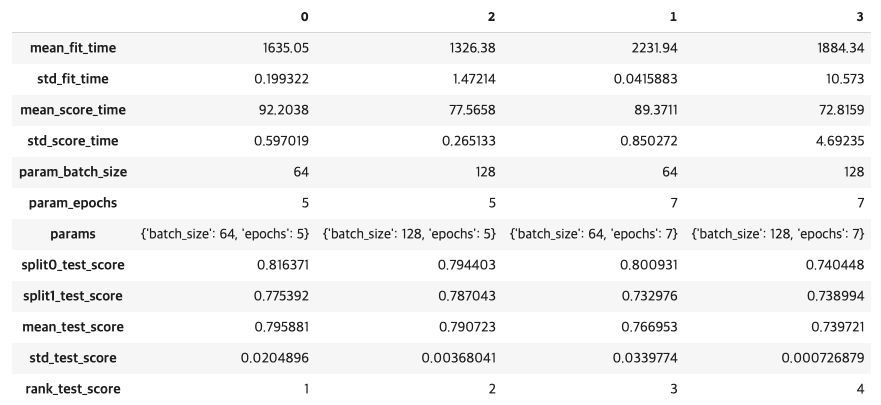

In [ ]:
# 2차 
# 변수 지정
embedding_size = 32

# Seed
np.random.seed(2)
tf.random.set_seed(2)

def model_build_2(drop_1=0.2):
  model_3 = Sequential(
      [
        Embedding(vocab_size,
                  embedding_size,
                  input_length = max_len),
        LSTM(256,
             return_sequences=True),
        Dropout(drop_1),
        Dense(256, 
              activation='relu',
              kernel_regularizer=regularizers.l1(0.00001)),
        Dropout(0.2),
        Dense(128, 
              activation='relu'),
        Dense(1, 
              activation='sigmoid')
      ]
  )
  model_3.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

  return model_3

# 모델 생성
model_3 = KerasClassifier(build_fn = model_build_2, epochs = 5, batch_size = 64, verbose=0)

# param_grid 설정
param_grid_2 = {'drop_1' : [0.2, 0.4]}

# GridSearch
grid_2 = GridSearchCV(estimator=model_3, param_grid=param_grid_2, n_jobs=-1, cv=2)
grid_result_2 = grid_2.fit(X_train, y_train)

In [ ]:
# best_params 선정
print(f'best_score:{grid_result_2.best_score_}')

best_score:0.8111699223518372


In [ ]:
# best score 확인
rs = pd.DataFrame(grid_result_2.cv_results_).sort_values(by='rank_test_score').head()
rs.T

,1,0
mean_fit_time,2452.63,2448.62
std_fit_time,5.3502,1.63641
mean_score_time,122.475,124.772
std_score_time,2.25402,0.0213926
param_drop_1,0.4,0.2
params,{'drop_1': 0.4},{'drop_1': 0.2}
split0_test_score,0.803626,0.799033
split1_test_score,0.818713,0.813986
mean_test_score,0.81117,0.806509
std_test_score,0.00754356,0.00747639


### **3-6. Booking.com 데이터 적용**

In [ ]:
# 파일 불러오기
url = '/content/drive/MyDrive/Colab Notebooks/Study/Codestate_AI/Session4/Session4_Project/df.csv'
df_book = pd.read_csv(url)

# 필요한 데이터만 추출
df_book['hotel_review_tok'] = df_book['hotel_review_good'] + ' ' + df_book['hotel_review_bad']
df_book = df_book.loc[0:49, ['id', 'hotel_review_token']]

df_book['id'] = 1

# 결과 확인
df_book.head()

,id,hotel_review_token
0,1,한적한분위기 야외풀 서비스 모두 훌륭합니다 식당이 부족해요 저렴하게 식사할 곳필요
1,1,친절했고 깨끗했으며 바다가 보이는 욕조뷰가 좋았습니다 딱히 없습니다
2,1,발코니 너무 좋았어요 샤워실이 이곳저곳이 낙후가 된것같아요 조식먹을 때 어떤사람은...
3,1,아침식사는 생각만큼 다양한 메뉴로 구성되어 있지는 않았습니다 다른 후기들의 비해 만...
4,1,아침 일찍 바다를 보며 커피한잔 마실 수 있어 좋았습니다 날씨에 영향이 많이 가는 ...


In [ ]:
# 불용어 지정
stop_list = "아 휴 아이구 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 의해서 연이서 이어서 잇따라 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 말하면 즉 구체적으로 말하자면 시작하여 시초에 이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓"
stop_list = stop_list.split()

stop_words_review_ent = set(stop_list + ['도', '이', '하다', '가', '에', '이다', '을', '들', '은', '는', '에서', '으로', '과', '의', '로', '를', '분들', '다',
                              '와', '적', '되어다', '것', '이라', '곳', '한', '인', '분', '하고', '고', '들다', '등', '또', '1', '까지', '때', '그리고',
                              '점', '2', '싶다', '잘', '더', '에도', '만', '라', '나', '요', '랑', '3', '역', '및', '이나', '개', '여서', '대',
                              '못', '4', 'ㅎㅎ', '내', '기', '서', '그', '면', '류', '게', '님', '맘', '두', '이상', '인데', '저', '제', '시',
                              '쉬', '박', '딱', '번', '중', '5', '일', '날', '움', '명', '전', '쪽', '함', '성', '장', '거', '듯', '해',
                              '엔', '편', '온', '임', '니', '하', '문', '잠', '식', '후',
                              '이', '하다', '가', '에', '한', '을', '은', '도', '를', '같다', '에서', '조금', '는', '으로', '이다', '의', '되다', '것', '들', '보다',
                              '안', '로', '점',  '인', '다', '아니다', '더', '되어다', '가다', '만', '못', '과', '이라', '수', '요', '그렇다', '2', '적', '나다', '1', '그리고', '고', '정도',
                              '그', '하고', '곳', '분', '느낌', '나', '받다', '들다', '에는', '등', '와', '부분', 'ㅠ', '까지', '기', '3', '인데', '하나', '라', '내', '서', '이나',
                              '제', '그냥', '듯', 'ㅠ', '매우', '싶다', '인지', '시', '객', '중', '돼다', '저', '엔', '거', '전', '지', '후', '랑', '대', '명', '잘', '성',
                              'ㅜㅜ', 'ㅎㅎ', '어', '위', '구', '건', '번', '외', '및'])

# 변수 선언
okt=Okt()

# Tokenize 함수 설정
def preprocessing(review, okt, remove_stopwords = False, stop_words = []):
    word_review = okt.morphs(review, stem=True)
    if remove_stopwords:
        word_review = [token for token in word_review if not token in stop_words]
    return word_review


clean_review_2 = []

# 함수 적용 - hotel_review_entire
for review in df_book['hotel_review_token'] :
    if type(review) == str :
        clean_review_2.append(preprocessing(review, okt, remove_stopwords=True, stop_words=stop_words_review_ent))
    else:
        clean_review_2.append([])

df_book.loc[:]['hotel_review_token'] = clean_review_2

# X_test로 저장
X_test = df_book['hotel_review_token']

,id,hotel_review_token
0,1,"[한적하다, 분위기, 야외, 풀, 서비스, 훌륭하다, 식당, 부족하다, 저렴하다, ..."
1,1,"[친절하다, 깨끗하다, 바다, 보이다, 욕조, 뷰, 좋다, 딱하다]"
2,1,"[발코니, 너무, 좋다, 샤워실, 낙후, 조식, 먹다, 일회용, 장갑, 끼, 끼다,..."
3,1,"[아침식사, 다양하다, 메뉴, 구성, 후기, 비다, 만족스럽다, 너무, 크다, 기대..."
4,1,"[아침, 일찍, 바다, 커피한잔, 말다, 좋다, 날씨, 영향, 많이, 덥다]"


In [ ]:
# CV Best Score Model에 X_test 적용
y_test = np.argmax(grid_result_2.predict(X_test), axis=-1)

# 데이터 프레임에 입력
df_book['id'] = y_test

## **4. Text Mining**

In [ ]:
# 작업이 꼬일 수 있어서 데이터를 새로 불러와 진행하였습니다
# 경로 지정
file_path = "/content/drive/MyDrive/Colab Notebooks/Study/Codestate_AI/Session4/Session4_Project/tripadvisor_hotel_reviews.csv"

# 파일 가져오기
df_trip = pd.read_csv(file_path)

# 데이터 전처리
df_trip['Review_tokens'] = df_trip['Review']
text_desc = []

for text in df_trip['Review'] :
    text = text.replace('\'', '').replace('\n', '').strip()
    doc_tokens = re.sub(r"[^a-z0-9]", " ", str(text))
    doc_tokens = doc_tokens.replace('  ', ' ')
    text_desc.append(doc_tokens)

# 리스트를 데이터 프레임에 반영
df_trip.loc[:]['Review_tokens'] = text_desc

# Label 변경
df_trip['Rating'] = df_trip['Rating'].replace(1, 3).replace(2, 3)
df_trip['Rating'] = df_trip['Rating'].replace(3, 0).replace(4, 1).replace(5, 1)

# 결과 확인
print(df_trip['Rating'].value_counts())

1    15093
0     5398
Name: Rating, dtype: int64


In [ ]:
# 데이터 분리
df_trip_po = df_trip[df_trip['Rating'] == 1]
df_trip_ne = df_trip[df_trip['Rating'] == 0]
df_trip_ne.head()

,Review,Rating,Review_tokens
1,ok nothing special charge diamond member hilto...,0,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,0,nice rooms not 4 experience hotel monaco seatt...
10,"poor value stayed monaco seattle july, nice ho...",0,poor value stayed monaco seattle july nice hot...
13,nice hotel not nice staff hotel lovely staff q...,0,nice hotel not nice staff hotel lovely staff q...
15,horrible customer service hotel stay february ...,0,horrible customer service hotel stay february ...


### **4-2. Tokenize**

In [ ]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_sm")
tokenizer = Tokenizer(nlp.vocab)

# 불용어 사전에 단어 추가 - Positive
STOP_WORDS_min = nlp.Defaults.stop_words.union(['nt', 4, 2, 5, 3, '4', 'hotel', 'great', 'good', 'nice', 'day', 'excellent', 'resort', 'like', 'little', '2', 'small', 'recommend', 'got', '5', 'trip', 'wonderful', '3', 'got'])

In [ ]:
# 불용어 처리 진행 - po
tokens = []
for doc in tokenizer.pipe(df_trip_po['Review_tokens']):
    doc_tokens = []
    for token in doc:
        if (token.text not in STOP_WORDS_min) & (token.is_punct == False) :
            doc_tokens.append(token.text)
    tokens.append(doc_tokens)

# 리스트를 데이터 프레임에 반영
df_trip_po['Review_tokens_stop'] = tokens

# 결과 확인
df_trip_po = df_trip_po[['Review_tokens_stop','Rating']]
df_trip_po.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Review_tokens_stop,Rating
0,"[expensive, parking, deal, stay, anniversary, ...",1
3,"[unique, stay, time, monaco, location, short, ...",1
4,"[stay, stay, went, seahawk, game, awesome, dow...",1
5,"[love, monaco, staff, husband, stayed, crazy, ...",1
6,"[cozy, stay, rainy, city, husband, spent, 7, n...",1


In [ ]:
# 불용어 처리 진행 - ne
tokens = []
for doc in tokenizer.pipe(df_trip_ne['Review_tokens']):
    doc_tokens = []
    for token in doc:
        if (token.text not in STOP_WORDS_min) & (token.is_punct == False) :
            doc_tokens.append(token.text)
    tokens.append(doc_tokens)

# 리스트를 데이터 프레임에 반영
df_trip_ne['Review_tokens_stop'] = tokens

# 결과 확인
df_trip_ne = df_trip_ne[['Review_tokens_stop','Rating']]
df_trip_ne.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Review_tokens_stop,Rating
1,"[ok, special, charge, diamond, member, hilton,...",0
2,"[rooms, experience, monaco, seattle, level, po...",0
10,"[poor, value, stayed, monaco, seattle, july, p...",0
13,"[staff, lovely, staff, rude, bellhop, desk, cl...",0
15,"[horrible, customer, service, stay, february, ...",0


### **4-3. Word counts 확인**

In [ ]:
# 결과 적용 및 확인 - Positive
wc_1 = word_count(df_trip_po['Review_tokens_stop'])
wc_1.head()

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
2,room,10053,23012,1.0,0.017589,0.017589,0.666070
99,staff,9225,12815,2.0,0.009795,0.027384,0.611210
20,stay,7613,11339,3.0,0.008667,0.036050,0.504406
48,location,6659,8952,4.0,0.006842,0.042892,0.441198
350,rooms,6121,8552,5.0,0.006537,0.049429,0.405552


In [ ]:
# 결과 적용 및 확인 - Negative
wc_2 = word_count(df_trip_ne['Review_tokens_stop'])
wc_2.head() 

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
122,room,4153,12344,1.0,0.022267,0.022267,0.769359
133,stay,2580,4074,2.0,0.007349,0.029616,0.477955
186,rooms,2412,3856,3.0,0.006956,0.036572,0.446832
62,staff,2543,3822,4.0,0.006894,0.043466,0.471100
57,night,2166,3482,5.0,0.006281,0.049747,0.401260


### **4-4. 결과 시각화**

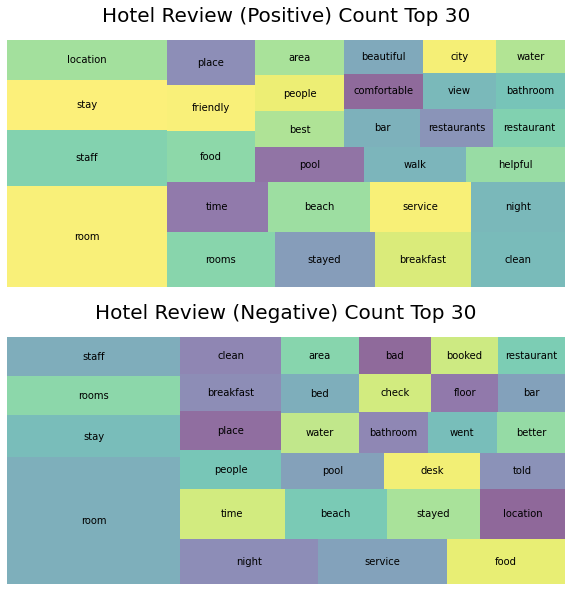

In [ ]:
# 변수 지정
wc_1_top30 = wc_1[wc_1['rank'] <= 30]
wc_2_top30 = wc_2[wc_2['rank'] <= 30]

# 차트 생성
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].set_title('Hotel Review (Positive) Count Top 30', size=20, y=1.05)
squarify.plot(sizes=wc_1_top30['percent'], label=wc_1_top30['word'], alpha=0.6, ax=axes[0], text_kwargs={'fontsize':10})
axes[0].axis('off')

axes[1].set_title('Hotel Review (Negative) Count Top 30', size=20, y=1.05)
squarify.plot(sizes=wc_2_top30['percent'], label=wc_2_top30['word'], alpha=0.6, ax=axes[1], text_kwargs={'fontsize':10})
axes[1].axis('off')

plt.show();